# Uncertainty Quantification in Graph Neural Networks
##### Project hand-in for 02456 Deep Learning @ Technical University of Denmark (Fall 2022)

In this notebook the key ideas behind Deep Evidential Learning will be presented and applied on a regression task using i) a simple 1D toy dataset for analyzing the model behaviour, ii) a synthetically created 3D graph dataset for being able to manipulate with OOD data as well as iii) the molecular 3D graph dataset QM7 for predicting molecular properties using an invariant message-passing network. This 3-step approach was chosen in order to break down the modeling task into simpler ones and for debugging purposes, both assisted in understanding how the models learn uncertainties.

**Authors:**
<br> Albert Kjøller Jacobsen      &nbsp;&emsp; (s194253@student.dtu.dk)
<br> Aron Djurhuus Jacobsen       &nbsp;&nbsp; (s194262@student.dtu.dk)
<br> Felix Borum Burmester        &nbsp;&emsp; (s194266@student.dtu.dk)
<br> Phillip Chavarria Højbjerg   &nbsp; (s184984@student.dtu.dk)

**Supervisor:** Mikkel Nørgaard Schmidt, DTU Compute


*NOTE: This notebook provides a quick run-down of the handed-in report with a special focus on providing the code associated to the reported results for reproducibility purposes. A detailed analysis of the obtained results is provided in the report.*

### Table of Contents <a class="anchor" id="0"></a>

- [1. Learning with uncertainty - why and how?](#1)
- [2. Towards self-conscious neural networks - Deep Evidential Learning](#2)
    - [2.1 - Modelling higher-order probabilities - the Normal-Inverse-Gamma distribution](#2.1)
    - [2.2 - Learning parameters of the NIG distribution](#2.2)
- [3. Deep Evidential Regression - evaluating the approach on a toy example](#3)
    - [3.1 - Training the 1D toy model](#3.1)
    - [3.2 - Evaluating the 1D toy model](#3.2)
- [4. Modeling graph-structured data - introducing Message-Passing Neural Networks](#4)
    - [4.1 - Restricting the feature space - invariance matters!](#4.1)
    - [4.2 - Defining the synthetic setup](#4.2)
    - [4.3 - Training the synthetic 3D model](#4.3)
    - [4.4 - Evaluating the synthetic 3D model](#4.4)
- [5. Applying uncertainty quantification to a down-stream task - Molecular Property prediction](#5)
    - [5.1 - The QM7 dataset](#5.1)
    - [5.2 - Training the model - predicting molecular energy](#5.2)
    - [5.3 - Evaluating the model](#5.3)
- [6. Discussion and Conclusion](#6)
- [7. Possible Extensions](#7)

### 0. Loading functionalities


In [1]:
import os, glob
from PIL import Image

import torch
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from tensorboard import notebook

from content.evaluate import evaluate_model

### 1. Learning with uncertainty - why and how? <a class="anchor" id="1"></a>

<span style="color:red"> Introducing the (general) problem of interest - why do we need uncertainties?</span>

Machine Learning (ML) models - e.g. Deep Neural Networks - are validly deployed for solving several down-stream tasks due to their data-driven nature which often performs on par with other approaches. Though using such approaches often result in high performing models, these should be deployed with care when the modelled output/decision can have critical costs if modelled improperly - e.g. when classifying patient-related treatment, when estimating depth for visually acting robots or when predicting properties of molecules used within the field of medicine development. As such, capturing uncertainty of a Machine Learning model is crucial for several down-stream tasks and is a hot research topic within the field of Machine Learning.

But what is uncertainty? In fact, the word "uncertainty" does not reduce to a single meaning, but can instead be separated into different types of uncertainty, namely **aleatoric** and **epistemic** uncertainty. While aleatoric uncertainty captures uncertainty within the observed data that a Machine Learning model uses for training, epistemic uncertainty captures uncertainty regarding the model's prediction such that high uncertainty is associated to Out-of-Domain (OOD) data points where the model has limited evidence.

<center>
    <table><tr>
    <td> <img src="figures/aleatoric_simple.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="figures/epistemic_simple.png" alt="Drawing" style="width: 250px;"/> </td>
    </tr></table>
</center>

*Figures taken from [Amini et al. - Deep Evidential Regression.](https://arxiv.org/pdf/1910.02600.pdf)*


### 2. Towards self-conscious neural networks - Deep Evidential Learning <a class="anchor" id="2"></a>

<span style="color:red"> How was  and what is Deep Evidential Learning? What have been done in the field and how did models perform when using this approach? </span>

What should be evident, is that aleatoric uncertainty can <span style="color:red"> always </span> be learned directly from data. More difficult is the task of modeling epistemic uncertainty, which one might think of as a kind of "self-conscious" or "self-aware" property of a model - it simply knows what it doesn't know and where it's predictive power is limited! One could argue that such a property should be a key component of all models that are to be deployed for solving a task. But how do we capture such "self-consciousness" when training deep neural networks?

While **Bayesian Neural Networks** validly provides the tools for obtaining representations of epistemic uncertainty by placing probabilistic priors on the parameters of a network, this model class suffers from several limitations - most <span style="color:red"> prominent </span> is the computational expense originating from e.g. the Monte Carlo sampling approach required as the analytical solution is <span style="color:red"> intractable </span> for deep neural networks.

Enter **Evidential Learning** - a method that approaches determination of epistemic uncertainty through an evidence acquisition process. Here, all acquired training points provides the basis for fitting a higher-order distribution, known as the **evidential distribution**, from which sampling results in lower-order likelihood functions. As such, this process directly places a higher-order prior on lower-order likelihood function rather than placing priors on network weights which is done when using Bayesian NNs.

In the paper [*Deep Evidential Regression* by Amini et al.](https://arxiv.org/pdf/1910.02600.pdf) they argue, that their method of using evidential learning on a regression task is new, as evidential learning has typically been applied for classification tasks <span style="color:red"> (as done by ... and ...) </span>. Furthermore, they argue that the task of defining a proper OOD exploited during training is unrealistic for most applications for most applications. Instead, they suggest an approach to evidential learning that solely leverages information from in-domain data points, yet still captures epistemic uncertainty on OOD data points.

So you might wonder were to start? In fact, training an evidential learning model using deep learning is quite straightforward - all we have to do is define the higher-order distribution of interest and setup a deep neural network that outputs the parameters of this distribution. How easy is that?

#### 2.1 - Modelling higher-order probabilities - the Normal-Inverse-Gamma distribution <a class="anchor" id="2.1"></a>

One way of approximating the higher-order, evidential distribution is by the use of the **Normal Inverse-Gamma (NIG) distribution**, for which the probability density function (PDF) is given by

$$
\begin{equation}
    p(\mu, \sigma^2 | \gamma, \nu, \alpha, \beta) =
        \frac{\beta^\alpha \sqrt{\nu}}
        {\Gamma(\alpha)\sqrt{2\pi\sigma^2}}
        \biggl ( \frac{1}{\sigma^2} \biggr )^{\alpha + 1}
        \exp \biggl (- \frac{2\beta + \nu ( \gamma - \mu )^2}{2\sigma^2}\biggr)
\end{equation}
$$

The NIG distribution assumes that the target, $(y_1, \dots, y_N)$ are i.i.d. and follow a Gaussian with unknown mean and variance, $\mu$ and $\sigma^2$, respectively. These are to be probabilistically estimated from the evidential priors. Assuming that observations are taken from a Gaussian (as Amini et al. argues) the evidential prior on the unknown mean, $\mu$, becomes a Gaussian prior, whereas the unknown variance, $\sigma^2$, gets assigned an Inverse-Gamma prior. This is summarized below:

$$
\begin{align*}
    (y_1, \dots, y_N) &\sim \mathcal{N}(\mu, \sigma^2) \\ \\
    \mu &\sim \mathcal{N}(\gamma, \sigma^2\nu^{-1}) \\
    \sigma^2 &\sim \Gamma^{-1}(\alpha, \beta)
\end{align*}
$$

For obtaining the expression given in the above equation, it is further assumed that the true posterior distribution can be estimated by a factorizable estimated posterior distribution, $q(\mu, \sigma^2) = p(\mu, \sigma^2 | y_1, \dots, y_N)$ such that $q(\mu, \sigma^2) = q(\mu) q(\sigma^2)$.

As such, this higher-order, evidential distribution can be sampled to obtain parameter-values $\mu_i$ and $\sigma_i^2$ that then define the lower-order likelihood distribution from which a variety of realizations can be sampled. The NIG distribution is implemented as a `class`-object below for visualizing the PDF when locking the parameters $\gamma, \nu, \alpha and \beta$ to specific values.

In [2]:
from scipy.special import gamma as Gamma
from scipy.stats import expon, gengamma

# Inspiration from here: https://deebuls.github.io/devblog/probability/python/plotting/matplotlib/2020/05/19/probability-normalinversegamma.html
class NIG:
    def __init__(self, gamma, nu, alpha, beta):

        self.gamma, self.nu, self.alpha, self.beta = gamma, nu, alpha, beta
        assert alpha > 0 and beta >= 0 and nu >= 0

    def pdf(self, mu, sigma2):
        t1 = ((self.beta)**self.alpha) * ((self.nu)**0.5)
        t2 = Gamma(self.alpha) * (sigma2 * (2 * np.pi)**0.5)
        t3 = (1 / sigma2**2)**(self.alpha + 1)
        t4 = expon.pdf((2*self.beta + self.nu * (mu - self.gamma)**2)/(2*sigma2**2))
        return (t1/t2)*t3*t4

    def plot(self, zoom_out=5, steps=100, axs=None, colorbar=False):

        # max_sig_squared = gengamma.ppf(zoom, self.alpha, self.beta) * self.nu

        max_sig_squared = zoom_out
        mu_range = np.linspace(self.gamma - 1 * max_sig_squared, self.gamma + 1 * max_sig_squared, num=steps)
        sigma_range = np.linspace(0.01, max_sig_squared, num=steps)

        mu_grid, sigma_grid = np.meshgrid(mu_range, sigma_range)
        pdf_mesh = self.pdf(mu_grid, sigma_grid)

        if axs:
            X, Y, Z = np.sqrt(self.nu / self.beta) * (mu_grid - self.gamma), sigma_grid / self.beta, pdf_mesh
            cplot = axs.contourf(X, Y, Z, 10, cmap='Blues')

            axs.axis('equal')
            axs.set_title(rf"$\gamma$ = {self.gamma}, $\nu$ = {self.nu}, $\alpha$ = {self.alpha}, $\beta$ = {self.beta}")
            axs.set_xlabel(r"$\sqrt{\frac{\nu}{\beta}}(\gamma - \mu)$")
            axs.set_ylabel(r"$\sigma^2 / \beta $")

            if colorbar == True:
                plt.colorbar(cplot)

Using the `NIG`-class we can plot how the distribution looks when fixing the parameter-values (inspiration taken from [here](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution)).

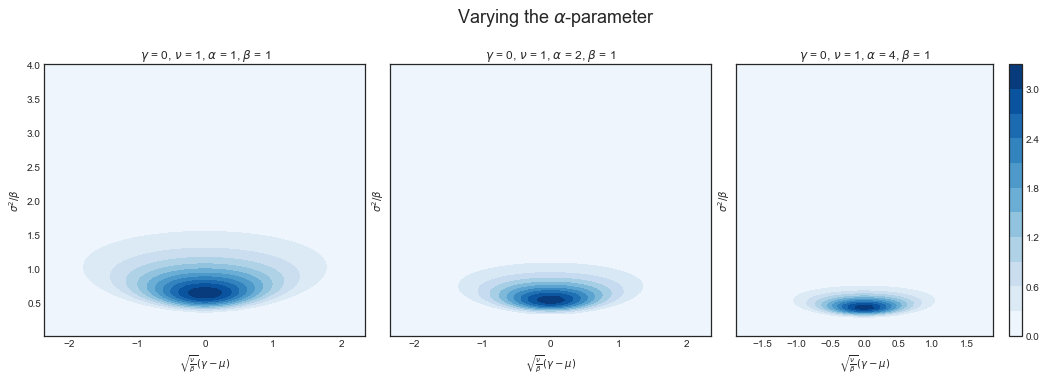

In [3]:
%matplotlib inline
plt.style.use('seaborn-white')

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
fig.suptitle(r'Varying the $\alpha$-parameter', fontsize=18)
fig.tight_layout(rect=[0, 0, 0.98, 0.95])

nig = NIG(gamma=0, nu=1, alpha=1,beta=1)
nig.plot(zoom_out=4.0, axs=axs[0])
nig = NIG(gamma=0, nu=1, alpha=2, beta=1)
nig.plot(zoom_out=4.0, axs=axs[1])
nig = NIG(gamma=0, nu=1, alpha=4, beta=1)
nig.plot(zoom_out=4.0, axs=axs[2], colorbar=True)

As can be seen on the above plot - where $\gamma=0, \nu=1$ and $\beta=1$ are set to (meaning that the axes corresponds to $-\mu$ and $\sigma^2$ respectively -, increasing the $\alpha$-parameter squeezes the area high probability mass towards a lower value of $\sigma^2$. This trend makes sense as the $\alpha$-parameter can be interpreted as virtual-observations (evidence) related to the $\sigma^2$-parameter.

##### What are the learned parameters useful for?
The parameters of the NIG distribution can be directly related to the prediction of the model as well as its aleatoric and epistemic uncertainties. These are defined as follows (in order 'prediction', 'aleatoric', 'epistemic'):

$$
    \mathbb{E}[\mu] = \gamma, \qquad\qquad \mathbb{E}[\sigma^2] = \frac{\beta}{\alpha - 1}, \qquad\qquad \text{Var}[\mu] = \frac{\beta}{\nu(\alpha - 1)}
$$

So, the setup proposed by Amini et al. provides a framework for decoupling the total uncertainty of the model into its aleatoric and epistemic subparts!

#### 2.2 - Learning parameters of the NIG distribution <a class="anchor" id="2.2"></a>

Similarly to other optimization task for deep learning, learning the parameters of the evidential distribution can be done through **Maximum Likelihood Estimation (MLE)**, thereby minimizing the **negative log-likelihood (NLL)**. Applying the NLL approach directly on the NIG distribution, the loss term becomes

\begin{equation}
    \mathcal{L}_i^{\mathrm{NLL}}(\boldsymbol{w})=\frac{1}{2} \log \left(\frac{\pi}{v}\right)-\alpha \log (\Omega)+\left(\alpha+\frac{1}{2}\right) \log \left(\left(y_i-\gamma\right)^2 v+\Omega\right)+\log \left(\frac{\Gamma(\alpha)}{\Gamma\left(\alpha+\frac{1}{2}\right)}\right)
\end{equation}

where $\Omega=2 \beta(1+v)$. The effect of this loss-term is that the neural network learns to fit observations by maximizing model evidence.

For emphasizing high epistemic uncertainty for OOD data points, an additional loss term penalizing model evidence by the absolute error of the model's prediction is included. This loss termand acts as a regularizer and is given by
\begin{equation}
    \mathcal{L}_i^{\mathrm{R}}(\boldsymbol{w})=\left|y_i-\gamma\right| \cdot(2 v+\alpha)
\end{equation}

The combined loss includes a scaling parameter, $\lambda$ on the regularization term and thus becomes
\begin{equation}
    \mathcal{L}_i(\boldsymbol{w})=\mathcal{L}_i^{\mathrm{NLL}}(\boldsymbol{w})+\lambda \mathcal{L}_i^{\mathrm{R}}(\boldsymbol{w})
\end{equation}

As Armini et al. argues, setting $\lambda=0$ results in an over-confident model for OOD data while a value of $\lambda$ too high will inflate model uncertainty. For respecting the natural structure of the NIG distribution, the learned parameters are restricted by applying various activation functions on the outputs of the output layer. As such $\gamma$ gets a linear activation as it equals the model prediction, $\nu$ and $\beta$ must be positive runs through a softplus activation, whereas $\alpha$ must be above 1 for which reason the softplus activation and addition of 1 is applied on the output level.

The total loss is implemented as a class, `NIGLoss`, containing all subparts of the total loss-function.

In [4]:
class NIGLoss:
    def __init__(self, lambd_) -> None:
        self.lambd_ = lambd_

    def __call__(self, evidential_params_, y):
        """
        Forward pass through the NIGLoss function.
        
        Parameters
        ----------
        evidential_params_: parameters of the evidential distribution (shape: batch_size x 4)
        y: target attribute of the regression task (shape: batch_size x 1)

        Returns
        -------
        A tuple of the total loss as well as a dictionary of "extra" losses / subparts of the total loss.
        ('Loss', total_loss), {'NLL': nll_loss, 'REG': reg_loss, 'RMSE': rmse_loss}
        
        """
        # Separate the evidential parameters
        self.gamma, self.nu, self.alpha, self.beta = evidential_params_[:, 0].reshape(-1, 1), \
                                                     evidential_params_[:, 1].reshape(-1, 1), \
                                                     evidential_params_[:, 2].reshape(-1, 1), \
                                                     evidential_params_[:, 3].reshape(-1, 1)

        # Compute NLL and regularization losses
        nll_loss = self.NIG_NLL(y)
        reg_loss = self.NIG_REGULARIZER(y)

        # Compute total loss
        total_loss = nll_loss + (self.lambd_ * reg_loss)
        return ('Loss', total_loss.mean()), {'NLL': nll_loss.mean(), 'REG': reg_loss.mean(), 'RMSE': torch.sqrt(torch.mean((self.gamma - y)**2))}

    def NIG_NLL(self, y):
        """
        Computes negative log-likelihood of the NIG distribution for a regression target, y. Maximizes model fit.
        Implementation follows Equation 8 in this paper (https://arxiv.org/pdf/1910.02600.pdf)
        
        """
        omega = 2 * self.beta * (1 + self.nu)
        nll = 0.5 * torch.log(torch.pi / (self.nu)) \
              - self.alpha * torch.log(omega) \
              + (self.alpha + 0.5) * torch.log((y-self.gamma)**2 * self.nu + omega) \
              + torch.lgamma(self.alpha) - torch.lgamma(self.alpha + 0.5)
        return nll

    def NIG_REGULARIZER(self, y):
        """
        Computes regularizing loss on the NIG distribution for a regression target, y. Minimizes evidence on errors by
        scaling the error with the total evidence of the infered posterior. 
        Implementation follows Equation 9 in this paper (https://arxiv.org/pdf/1910.02600.pdf)
        
        """
        return abs(y - self.gamma) * (2*self.nu + self.alpha)

### 3. Deep Evidential Regression - evaluating the approach on a toy example <a class="anchor" id="3"></a>

Thinking of aleatoric and epistemic uncertainties for multi-dimensional data is abstract and these concepts are often hard to grasp with as defining In- and Out-of-Domain data can be a hard task. For this reason, the evidential learning strategy using the defined NIG loss is applied to a simple 1D example where the various uncertainty types can be interpreted visually.

The 1D toy regression task consists in approximating a 3rd order polynomial where observations of the target variable are affected by a noise source. This noise is modelled as Gaussian noise with a variance of 3 and the problem can be described as

$$
    y = x^3 + \epsilon, \qquad \epsilon \sim \mathcal{N}(0, 3)
$$

The regression task at hand then consists of learning to approximate the 3rd order polynomial using a restricted training set, i.e. $x \in [-4, 4]$. During validation the model is further evaluated on OOD data, i.e. $x \in [-6, 6]$. As the purpose is only to visually inspect the evidential learning approach, no test dataset is defined.

Using the auxiliary function `load_data` (found in content/modules/utils.py) this simple regression problem is loaded as a dictionary containing a train, validation and test set.

In [5]:
from content.modules.utils import load_data

# Specify arguments for the load_data function
DATA_DIR = f'data'
DATASET = 'TOY1D'
BATCH_SIZE = 128
N_POINTS = 1024
DEVICE ='cuda'

# Create configuration dictionary
args = OmegaConf.create({'data_dir': DATA_DIR, 'dataset': DATASET, 'N_points': N_POINTS, 'toy_noise_level': 3,
                         'batch_size': BATCH_SIZE, 'device': DEVICE})

# Create dataloaders
dataloaders = load_data(args)
print(f"Loaded toy dataset!\nDataset types available: {[type_ for type_ in dataloaders.keys() if dataloaders[type_] != None]}")

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
<span style="color:red"> NIG Loss formulas </span>.

#### 3.1 - Training the 1D toy model <a class="anchor" id="3.1"></a>

Following the descriptions of the evidential learning problem previously mentioned, the `EvidentialToyModel1D` is defined below. The model takes a one-dimensional input and forward it through a neural network that outputs the four parameters for the evidential distribution with their respective output activations. Though pilot runs were carried out using the architecture from Amini et al. (3 hidden layers with 100 neurons each) we use a simplified architecture of only one hidden layer as the regression task is rather simple. Design choices include initializing the weights using the Kaiming Normal method due to using the ReLU activation function as well as adding an epsilon to some of the outputted parameters (for numerical reasons when computing the loss).

In [ ]:
# NIG Loss (IMPLEMENT ME!)

We use the Adam optimizer and hyperparameters specified in the cell below.

In [ ]:
from run import determine_run_version

# TRAINING-RELATED PARAMETERS
LR = 5e-3
HIDDEN_DIM = 100
LOSS_FUNCTION = 'NIGLoss'
NIG_LAMBDA = 0.01
EPOCHS = 625
SEED = 0
DEVICE = 'cuda'

# EXPERIMENT-RELATED PARAMETERS
VAL_EVERY_STEP = 5
EXPERIMENT_VERSION = 'v1'
EXPERIMENT_NAME = 'TOY1D'
TENSORBOARD_LOGDIR = 'logs'
SAVE_PATH = 'models'

args = OmegaConf.create({
    'experiment_name': f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}",
    'dataset': DATASET,
    'batch_size': BATCH_SIZE,
    'loss_function': LOSS_FUNCTION,
    'NIG_lambda': NIG_LAMBDA,
    'lr': LR,
    'epochs': EPOCHS,
    'seed': SEED,
    'device': DEVICE,
})

Now, training the model is straight-forward - just look below! The training loop is defined as a function which can be found in the file content/train.py and images revealing how aleatoric and epistemic uncertainties as well as values of the evidential parameters are distributed over the validation range, $x \in [-6, 6]$, are saved and used for visualizations later on.

In [ ]:
from content.train import train

# TRAINING-RELATED CLASSES
model = EvidentialToyModel1D(hidden_dim=HIDDEN_DIM)
model.to(torch.device(args.device))

loss_function = NIGLoss(lambd_=NIG_LAMBDA)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Run training loop
os.makedirs(f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}", exist_ok=True)
model, best_epoch = train(dataloaders, model, optimizer, loss_function, epochs=EPOCHS,
                          val_every_step=VAL_EVERY_STEP, experiment_name=f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}",
                          tensorboard_logdir=TENSORBOARD_LOGDIR, tensorboard_filename=determine_run_version(args),
                          save_path=f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")

In [ ]:
# load data - from repo (IMPLEMENT ME!)

#### 3.1 - Training the 1D toy model <a class="anchor" id="3.1"></a>

In [ ]:
# code for model implementation (IMPLEMENT ME!)

In [ ]:
# load training loop - from content (IMPLEMENT ME!)

In [ ]:
# CHECK THIS (IMPLEMENT ME!)
%load_ext tensorboard
%tensorboard --logdir logs

#### 3.2 - Evaluating the 1D toy model <a class="anchor" id="3.2"></a>


In [ ]:
# code for evaluation here - produce table and calibration plots (IMPLEMENT ME!)

##### 3.2.1 - Out-of-Distribution performance

In [ ]:
# code for doing a stratified evaluation on OOD data - table and calibration plots (IMPLEMENT ME!)

### 4. Modeling graph-structured data - introducing Message-Passing Neural Networks <a class="anchor" id="4"></a>

<span style="color:red"> Describe problem setup and how data is created </span>


In [1]:
import torch
import os

In [2]:
class EvidentialGNN3D(torch.nn.Module):
    """Translation and rotation invariant graph neural network.

    Keyword Arguments
    -----------------
        output_dim : Dimension of output (default 2)
        state_dim : Dimension of the node states (default 10)
        num_message_passing_rounds : Number of message passing rounds
            (default 3)
    """

    def __init__(self, device, state_dim=10, num_message_passing_rounds=3, eps=1e-10):
        super().__init__()
        self.model_type = 'evidential'

        # Set input dimensions and other hyperparameters
        self.state_dim = state_dim
        self.num_message_passing_rounds = num_message_passing_rounds

        # Define locked parameters
        self.edge_dim = 1
        self.output_dim = 4
        self.num_features = 4
        self.hidden_dim = 40

        # Message passing networks
        self.message_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(self.state_dim + self.num_features).double(),
            torch.nn.Linear(self.state_dim + self.num_features, self.hidden_dim).double(),
            torch.nn.Dropout(0.5),
            torch.nn.Tanh(),
            torch.nn.Linear(self.hidden_dim, 150).double(),
            torch.nn.Dropout(0.2),
            torch.nn.Tanh(),
            torch.nn.Linear(150, self.hidden_dim).double(),
            torch.nn.Dropout(0.8),
            torch.nn.Tanh(),
            torch.nn.Linear(self.hidden_dim, self.state_dim).double(),
            torch.nn.Dropout(0.5),
            torch.nn.Tanh(),
        )

        # Output net
        self.output_net = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim, self.output_dim).double() # (gamma, v, alpha, beta)
        )

        # Initialize weights
        self.message_net.apply(self.init_weights)
        self.output_net.apply(self.init_weights)

        # Speficy activation functions
        self.softplus = torch.nn.Softplus()

        # Utilize GPU? #TODO: move this out of the class itself and into the run-script
        self.device = device
        self.eps = eps
        self.to(device)
          
    def init_weights(self, layer): # Found here: https://www.askpython.com/python-modules/initialize-model-weights-pytorch
        if type(layer) == torch.nn.Linear:
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu').double() # Kaiming for Relu
    

    def forward(self, x):
        """Evaluate neural network on a batch of graphs.

        Parameters
        ----------
        x: GraphDataset
            A data set object that contains the following member variables:

            node_coordinates : torch.tensor (N x 2)
                2d coordinates for each of the N nodes in all graphs
            node_graph_index : torch.tensor (N)
                Index of which graph each node belongs to
            edge_list : torch.tensor (E x 2)
                Edges (to-node, from-node) in all graphs
            node_to, node_from : Shorthand for column 0 and 1 in edge_list
            edge_lengths : torch.tensor (E)
                Edge features

        Returns
        -------
        out : N x output_dim
            Neural network output

        """
        # Initialize node features to zeros
        self.state = torch.zeros([x.num_nodes, self.state_dim]).to(self.device).double()

        # Loop over message passing rounds
        for _ in range(self.num_message_passing_rounds):
            # Preparing features
            e_len = x.edge_lengths
            coord_difference = torch.sum(torch.abs(x.node_coordinates[x.node_from] - x.node_coordinates[x.node_to]), axis=1)
            dot_coord = dot3D(x.node_coordinates[x.node_from], x.node_coordinates[x.node_to]).view(x.edge_lengths.shape)
            dot_diff = dot3D((x.node_coordinates[x.node_from] - x.node_coordinates[x.node_to]), x.edge_vectors).view(x.edge_lengths.shape)

            # Stacking features
            inp = torch.cat((self.state[x.node_from], 
                            e_len, 
                            coord_difference.view(e_len.shape),
                            dot_coord.view(e_len.shape),
                            dot_diff.view(e_len.shape),
                            ), 1)

            message = self.message_net(inp)

            if int(sum(sum(torch.isnan(message)))) > 0:
                stop = 1

            # Aggregate: Sum messages
            self.state.index_add_(0, x.node_to, message)
        # Aggretate: Sum node features
        self.graph_state = torch.zeros((x.num_graphs, self.state_dim)).to(self.device).double()
        self.graph_state.index_add_(0, x.node_graph_index, self.state)

        # Get parameters of NIG distribution (4-dimensional output)
        evidential_params_ = self.output_net(self.graph_state) # (gamma, v, alpha, beta)
        # Apply activations as specified after Equation 10 in the paper
        gamma, v, alpha, beta = torch.tensor_split(evidential_params_, 4, axis=1)
        out = torch.concat([gamma, self.softplus(v) + self.eps, self.softplus(alpha).add(1.0).to(torch.float64) + self.eps, self.softplus(beta) + self.eps], axis=1)
        return out

class BaselineGNN3D(torch.nn.Module):
    """Translation and rotation invariant graph neural network.

        Keyword Arguments
        -----------------
            output_dim : Dimension of output (default 2)
            state_dim : Dimension of the node states (default 10)
            num_message_passing_rounds : Number of message passing rounds
                (default 3)
        """

    def __init__(self, device, state_dim=100, num_message_passing_rounds=3):
        super().__init__()
        self.model_type = 'baseline'

        # Set input dimensions and other hyperparameters
        self.state_dim = state_dim
        self.num_message_passing_rounds = num_message_passing_rounds

        # Define locked parameters
        self.edge_dim = 1
        self.output_dim = 2
        self.num_features = 4
        self.hidden_dim = 40

        # Message passing networks
        self.message_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(self.state_dim + self.num_features).double(),
            torch.nn.Linear(self.state_dim + self.num_features, self.hidden_dim).double(),
            torch.nn.Dropout(0.5),
            torch.nn.Tanh(),
            torch.nn.Linear(self.hidden_dim, 150).double(),
            torch.nn.Dropout(0.2),
            torch.nn.Tanh(),
            torch.nn.Linear(150, self.hidden_dim).double(),
            torch.nn.Dropout(0.8),
            torch.nn.Tanh(),
            torch.nn.Linear(self.hidden_dim, self.state_dim).double(),
            torch.nn.Dropout(0.5),
            torch.nn.Tanh(),
        )

        # Output net
        self.output_net = torch.nn.Sequential(
            torch.nn.Linear(self.state_dim, self.output_dim).double()  # (gamma, v, alpha, beta)
        )

        # Initialize weights
        self.message_net.apply(self.init_weights)
        self.output_net.apply(self.init_weights)

        # Speficy activation functions
        self.softplus = torch.nn.Softplus()

        # Utilize GPU? #TODO: move this out of the class itself and into the run-script
        self.device = device
        self.to(device)

    def init_weights(self,
                     layer):  # Found here: https://www.askpython.com/python-modules/initialize-model-weights-pytorch
        if type(layer) == torch.nn.Linear:
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out',
                                          nonlinearity='relu').double()  # Kaiming for Relu

    def forward(self, x):
        """Evaluate neural network on a batch of graphs.

        Parameters
        ----------
        x: GraphDataset
            A data set object that contains the following member variables:

            node_coordinates : torch.tensor (N x 2)
                2d coordinates for each of the N nodes in all graphs
            node_graph_index : torch.tensor (N)
                Index of which graph each node belongs to
            edge_list : torch.tensor (E x 2)
                Edges (to-node, from-node) in all graphs
            node_to, node_from : Shorthand for column 0 and 1 in edge_list
            edge_lengths : torch.tensor (E)
                Edge features

        Returns
        -------
        out : N x output_dim
            Neural network output

        """
        # Initialize node features to zeros
        self.state = torch.zeros([x.num_nodes, self.state_dim]).double().to(self.device)

        # Loop over message passing rounds
        for _ in range(self.num_message_passing_rounds):
            e_len = x.edge_lengths
            coord_difference = torch.sum(torch.abs(x.node_coordinates[x.node_from] - x.node_coordinates[x.node_to]),
                                         axis=1)
            dot_coord = dot3D(x.node_coordinates[x.node_from], x.node_coordinates[x.node_to]).view(x.edge_lengths.shape)
            dot_diff = dot3D((x.node_coordinates[x.node_from] - x.node_coordinates[x.node_to]), x.edge_vectors).view(
                x.edge_lengths.shape)

            # Stacking features
            inp = torch.cat((self.state[x.node_from],
                             e_len,
                             coord_difference.view(e_len.shape),
                             dot_coord.view(e_len.shape),
                             dot_diff.view(e_len.shape),
                             ), 1)
            message = self.message_net(inp)

            # Aggregate: Sum messages
            self.state.index_add_(0, x.node_to, message)

        # Aggretate: Sum node features
        self.graph_state = torch.zeros((x.num_graphs, self.state_dim)).double().to(self.device)
        self.graph_state.index_add_(0, x.node_graph_index, self.state)

        # Get parameters of NIG distribution (4-dimensional output)
        evidential_params_ = self.output_net(self.graph_state)  # (gamma, v, alpha, beta)
        # Apply activations as specified after Equation 10 in the paper
        mu, sigma = torch.tensor_split(evidential_params_, 2, axis=1)
        out = torch.concat([mu, self.softplus(sigma)], axis=1)
        return out

def cross2D(v1, v2):
    """Compute the 2-d cross product.

    Parameters
    ----------
    v1, v2 : Array
        Arrays (shape Nx2) containing N 2-d vectors

    Returns
    -------
    Array
        Array (shape N) containing the cross products

    """
    return v1[:, 0] * v2[:, 1] - v1[:, 1] * v2[:, 0]

def dot3D(v1, v2):
    """Compute the 2-d dot product.

    Parameters
    ----------
    v1, v2 : Array
        Arrays (Nx2) containing N 3-d vectors

    Returns
    -------
    Array
        Array (shape N) containing the dot products

    """
    return v1[:, 0] * v2[:, 0] + v1[:, 1] * v2[:, 1] + v1[:, 2] * v2[:, 2]




#### 4.1 Restricting the feature space - invariance matters! <a class="anchor" id="4.1"></a>

<span style="color:red"> The concept of invariance! Why does it matter? </span>


#### 4.2 - Defining the synthetic setup <a class="anchor" id="4.2"></a>

In order to validate that our model works, we evaluate the model on synthetically generated data. We create the data by sampling atoms in a vector space. We use sklearn's "make_blobs" to sample these atoms. It works by defining finite a 3D coordinate system, for instance by defining a box between -5 and 5 on all three axes. In this box, we sample $n$ clusters at random. An atom is then sampled from a gaussian distribution with mean at a cluster point and standard deviation of 0.1. This way, we get $n$ atoms in our sampled molecule.

The distance between these atoms are now computed and given as edge weights in the fully connected graph that defines the molecule. The value used for prediction is retrieved by computing the force between molecules based on this force function:

$$
U(x) = \frac{a}{x^{12}} - \frac{b}{x^6}
$$

Where $a$ and $b$ are constants that we set to $a=500000$ and $b=4000$. We did this in order to make sure that we could get data with distances that would return different force-values (U(x)). The formula itself was found [here](https://www.toppr.com/ask/question/the-potential-energy-function-for-the-force-between-two-atoms/). The important part of this formula is that it is non-linear (see the next figure). In order for our loss not to get out of hand, we cap $U(x)$ at 1000; if $U(x)>1000$, $U(x)=1000$.

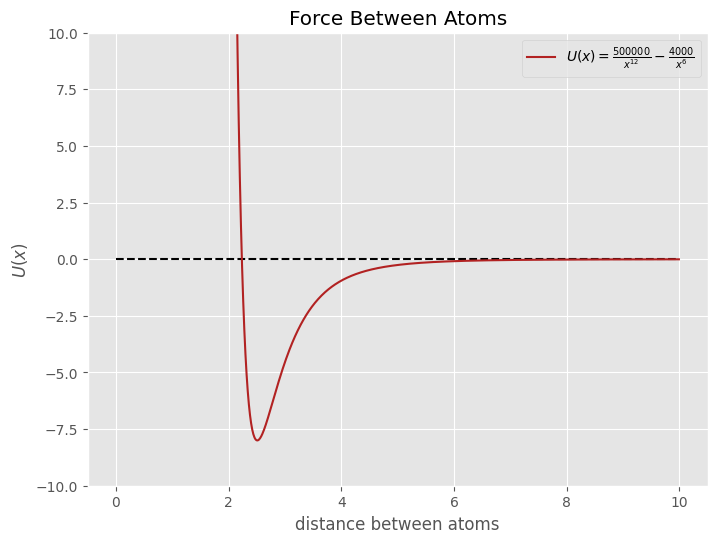

In [3]:
from content.plot_force_function import plot_gg
from content.synthetic_data_generation import U
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.1,10,0.01)
y = np.array([U(xi) for xi in x])

plt.figure(figsize=(8,6),dpi=100)
plot_gg(x,y)

What is interesting about the synthetic data is that we know all about the environment and how it should behave. Therefore, we can create data that is out of distribution (OOD) while knowing nothing about chemistry - which would be required to do the same thing on real molecular data!

We create three synthetic datasets. The only difference between them is the finite box of sampled atoms mentioned earlier. We call this the centerbox, and they are the following:

- One dataset with a centerbox-span from -0.5 to 0.5
- One with a centerbox-span from -2 to 2
- And finally one with a span from -10 to 10

Their mean distances and standard deviation of these can be seen below:


NEED TO UPDATE PLOT!

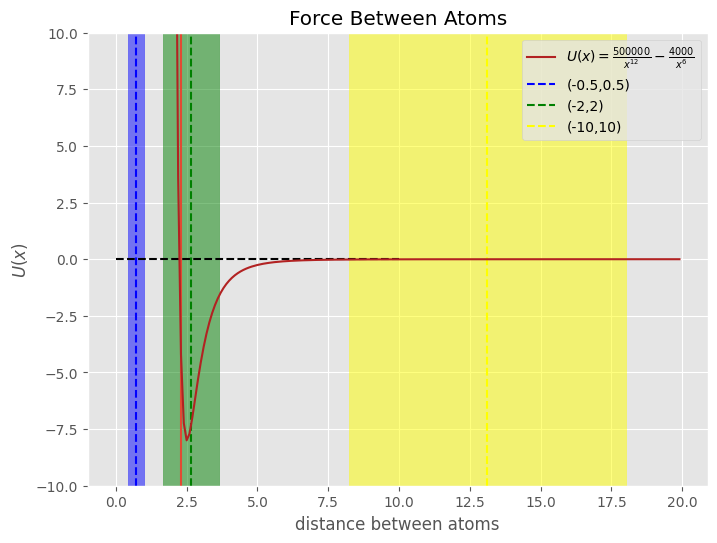

In [4]:
from content.plot_force_function import plot_gg_mstd
x = np.arange(0.1,20,0.1)
y = np.array([U(xi) for xi in x])
plt.figure(figsize=(8,6),dpi=100)
plt.vlines(2.30,-10,10)
plot_gg_mstd(x,y)

The vertical lines are the mean of the distances in the dataset and the span around the lines is the standard deviation. One should note here that there is a small overlap between min and max of the distinct datasets, however, we argue that it is still possible to keep them separate and say that these are from distinct and different distributions due to the fact that the sampled overlaps are few and can be classified as outliers in the distributions.

#### 4.3 - Training the synthetic 3D model <a class="anchor" id="4.3"></a>

In [5]:
#Should be run in Albert's part:
class NIGLoss:
    def __init__(self, lambd_) -> None:
        self.lambd_ = lambd_

    def __call__(self, evidential_params_, y):
        """
        Forward pass through the NIGLoss function.
        
        Parameters
        ----------
        evidential_params_: parameters of the evidential distribution (shape: batch_size x 4)
        y: target attribute of the regression task (shape: batch_size x 1)

        Returns
        -------
        A tuple of the total loss as well as a dictionary of "extra" losses / subparts of the total loss.
        ('Loss', total_loss), {'NLL': nll_loss, 'REG': reg_loss, 'RMSE': rmse_loss}
        
        """
        # Separate the evidential parameters
        self.gamma, self.nu, self.alpha, self.beta = evidential_params_[:, 0].reshape(-1, 1), \
                                                     evidential_params_[:, 1].reshape(-1, 1), \
                                                     evidential_params_[:, 2].reshape(-1, 1), \
                                                     evidential_params_[:, 3].reshape(-1, 1)

        # Compute NLL and regularization losses
        nll_loss = self.NIG_NLL(y)
        reg_loss = self.NIG_REGULARIZER(y)
        # Compute total loss
        total_loss = nll_loss + (self.lambd_ * reg_loss)
        return ('Loss', total_loss.mean()), {'NLL': nll_loss.mean(), 'REG': reg_loss.mean(), 'RMSE': torch.sqrt(torch.mean((self.gamma - y)**2))}

    def NIG_NLL(self, y):
        """
        Computes negative log-likelihood of the NIG distribution for a regression target, y. Maximizes model fit.
        Implementation follows Equation 8 in this paper (https://arxiv.org/pdf/1910.02600.pdf)
        
        """
        omega = 2 * self.beta * (1 + self.nu)
        nll = 0.5 * torch.log(torch.pi / (self.nu)) \
              - self.alpha * torch.log(omega) \
              + (self.alpha + 0.5) * torch.log((y-self.gamma)**2 * self.nu + omega) \
              + torch.lgamma(self.alpha) - torch.lgamma(self.alpha + 0.5)
        return nll

    def NIG_REGULARIZER(self, y):
        """
        Computes regularizing loss on the NIG distribution for a regression target, y. Minimizes evidence on errors by
        scaling the error with the total evidence of the infered posterior. 
        Implementation follows Equation 9 in this paper (https://arxiv.org/pdf/1910.02600.pdf)
        
        """
        return abs(y - self.gamma) * (2*self.nu + self.alpha)


In [6]:
from torch.nn import GaussianNLLLoss
class GAUSSIANNLLLoss:
    def __init__(self, l=0) -> None:
        self.l=0
        pass

    def __call__(self, theta, y):
        self.mu = theta[:,0].reshape(-1,1)
        self.sigma = theta[:, 1].reshape(-1, 1)

        # Compute loss
        loss = GaussianNLLLoss()
        nll_loss = loss(input=self.mu, target=y, var=self.sigma)
        return ('GAUSSIANNLL', torch.sqrt(nll_loss.mean())), {}

In order to train the models on the synthetic data set, we need to load the dataset to be trained on. The data we will be training on is the green span seen above; center box from -2 to 2.

In [7]:
from content.modules.utils import load_data
from omegaconf import OmegaConf

# Specify arguments for the load_data function
DATA_DIR = f'content/data'
DATASET = 'SYNTHETIC4'
BATCH_SIZE = 32
DEVICE ='cpu'
SEED = 42

# Create configuration dictionary
args = OmegaConf.create({'data_dir': DATA_DIR, 'dataset': DATASET,
                         'batch_size': BATCH_SIZE, 'device': DEVICE, 'seed': SEED})

# Create dataloaders
dataloaders = load_data(args)
print(f"Loaded toy dataset!\nDataset types available: {[type_ for type_ in dataloaders.keys() if dataloaders[type_] != None]}")


CREATING DATALOADER OBJECTS...

SUCCESSFULLY CREATED AND SAVED DATALOADER OBJECTS!
Loaded toy dataset!
Dataset types available: ['train', 'val', 'test']


Now we run both the Evidential GNN and our Gaussian MLE baseline on SYNTHETIC2 (center box = -2,2).

In [8]:
from run import determine_run_version

args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
state_dim = 20
args.lr = LR = 5e-2
args.loss_function = LOSS_FUNCTION = 'NIGLoss'
args.epochs = EPOCHS = 1500
args.seed = SEED = 2
args.device = DEVICE = 'cpu'

# EXPERIMENT-RELATED PARAMETERS
VAL_EVERY_STEP = 5
EXPERIMENT_NAME = 'EviGNN_SYNTHETIC4_-2lr_20stdim'
args.tensorboard_logdir = TENSORBOARD_LOGDIR = 'logs'
args.save_path = SAVE_PATH = 'models'

# DATASET
args.batch_size = BATCH_SIZE
args.dataset = DATASET

In [9]:
from content.train import train
import numpy as np
best_epochs = {}
torch.manual_seed(1)
np.random.seed(1)
args.NIG_lambda = NIG_LAMBDA = 0.01
EXPERIMENT_VERSION = f'lambda{NIG_LAMBDA}'
args.experiment_name = f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}"

# TRAINING-RELATED CLASSES
model = EvidentialGNN3D(device=args.device,state_dim=state_dim)
model.to(torch.device(args.device))

loss_function = NIGLoss(lambd_=NIG_LAMBDA)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Run training loop
os.makedirs(f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
model, best_epoch = train(dataloaders, model, optimizer, loss_function, epochs=EPOCHS,
                          val_every_step=VAL_EVERY_STEP, experiment_name=f"{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}",
                          tensorboard_logdir=TENSORBOARD_LOGDIR, tensorboard_filename=determine_run_version(args),
                          save_path=f"{SAVE_PATH}/{EXPERIMENT_NAME}-{EXPERIMENT_VERSION}")
best_epochs[NIG_LAMBDA] = best_epoch

Train Loss: 3.589 	| 	 Val Loss: 3.415 	| 	 Val RMSE: 6.979 | Progress: 100%|██████████| 1500/1500 [05:06<00:00,  4.89it/s]


EPOCH 260 --> BEST CHECKPOINT SAVED!	 Validation Loss: 3.3782406711822


In [ ]:
from run import determine_run_version

args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
state_dim = 20
args.lr = LR = 5e-2
args.loss_function = LOSS_FUNCTION = "GAUSSIANNLL"
args.epochs = EPOCHS = 1000
args.seed = SEED = 2
args.device = DEVICE = 'cpu'
args.model = 'BASE3D'

# EXPERIMENT-RELATED PARAMETERS
VAL_EVERY_STEP = 5
EXPERIMENT_NAME = 'BaseGNN_SYNTHETIC4_-2lr_20stdim'
args.tensorboard_logdir = TENSORBOARD_LOGDIR = 'logs'
args.save_path = SAVE_PATH = 'models'

# DATASET
args.batch_size = BATCH_SIZE
args.dataset = DATASET

In [ ]:
from content.train import train
import numpy as np

best_epochs = {}
torch.manual_seed(1)
np.random.seed(1)
#args.NIG_lambda = NIG_LAMBDA = 0.01
#EXPERIMENT_VERSION = f'lambda{NIG_LAMBDA}'
args.experiment_name = EXPERIMENT_NAME

# TRAINING-RELATED CLASSES
model = BaselineGNN3D(device=args.device,state_dim=state_dim)
model.to(torch.device(args.device))

loss_function = GAUSSIANNLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Run training loop
os.makedirs(f"{SAVE_PATH}/{EXPERIMENT_NAME}")
model, best_epoch = train(dataloaders, model, optimizer, loss_function, epochs=EPOCHS,
                          val_every_step=VAL_EVERY_STEP, experiment_name=f"{EXPERIMENT_NAME}",
                          tensorboard_logdir=TENSORBOARD_LOGDIR, tensorboard_filename=determine_run_version(args),
                         save_path=f"{SAVE_PATH}/{EXPERIMENT_NAME}")
#best_epochs[NIG_LAMBDA] = best_epoch

#### 4.4 - Evaluating the synthetic 3D model <a class="anchor" id="4.4"></a>

In [ ]:
from omegaconf import OmegaConf
from content.modules.utils import load_data

DATA_DIR = 'content/data'
BATCH_SIZE = 32
SAVE_PATH = 'models'
SEED = 0

args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
args.mode = 'evaluation'
args.data_dir = DATA_DIR
args.batch_size = BATCH_SIZE
args.dataset = ['SYNTHETIC4', 'SYNTHETIC3']
args.id_ood = ['ID', 'OOD']

args.model = ['GNN3D','GNN3D']
args.experiment_name = ['EviGNN_SYNTHETIC4_-2lr_20stdim-lambda0.01','EviGNN_SYNTHETIC4_-2lr_20stdim-lambda0.01']
args.save_path = SAVE_PATH
args.device = 'cpu'
args.seed = SEED

In [ ]:
from copy import deepcopy
from content.modules.utils import load_model
from content.evaluate import evaluate_model

models = {}
loaders_dict = {}
# getting each model
for idx, exp in enumerate(args.experiment_name):
    curr_args = deepcopy(args)
    curr_args.experiment_name, curr_args.model = exp, args.model[idx]
    # model
    models[exp] = load_model(curr_args)
    #print(idx, exp)

# getting each dataset loader
for idx, data in enumerate(args.dataset):
    curr_args = deepcopy(args)
    curr_args.dataset =args.dataset[idx]
    # dataset
    loaders_dict[args.id_ood[idx]] = load_data(curr_args)

table_results = evaluate_model(loaders_dict=loaders_dict, models=models, experiments=args.experiment_name, args = args)

In [20]:
from omegaconf import OmegaConf
from content.modules.utils import load_data

DATA_DIR = 'content/data'
BATCH_SIZE = 16
SAVE_PATH = 'models'
SEED = 0

args = OmegaConf.create({})

# TRAINING-RELATED PARAMETERS
args.mode = 'evaluation'
args.data_dir = DATA_DIR
args.batch_size = BATCH_SIZE
args.dataset = ['SYNTHETIC05','SYNTHETIC05']
args.id_ood = ['OOD','OOD']

args.model = ['GNN3D', 'BASE3D']
args.experiment_name = ['EviGNN_SYNTHETIC2-lambda0.01','BaseGNN_SYNTHETIC2']
args.save_path = SAVE_PATH
args.device = 'cpu'
args.seed = SEED


LOADED DATALOADER OBJECTS!

LOADED DATALOADER OBJECTS!
Save folder already exists


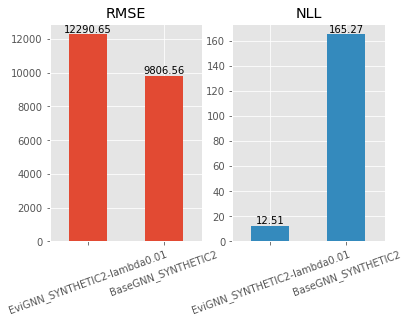

In [21]:
from copy import deepcopy
from content.modules.utils import load_model
from content.evaluate import evaluate_model

models = {}
loaders_dict = {}
# getting each model
for idx, exp in enumerate(args.experiment_name):
    curr_args = deepcopy(args)
    curr_args.experiment_name, curr_args.model = exp, args.model[idx]
    # model
    models[exp] = load_model(curr_args)

# getting each dataset loader
for idx, data in enumerate(args.dataset):
    curr_args = deepcopy(args)
    curr_args.dataset =args.dataset[idx]
    # dataset
    loaders_dict[args.id_ood[idx]] = load_data(curr_args)

table_results = evaluate_model(loaders_dict=loaders_dict, models=models, experiments=args.experiment_name, args = args)

### 5. Applying uncertainty quantification to a down-stream task - Molecular Property prediction <a class="anchor" id="5"></a>


#### 5.1 - The QM7 dataset <a class="anchor" id="5.1"></a>

#### 5.2 - Training the model - predicting molecular energy <a class="anchor" id="5.2"></a>


#### 5.3 - Evaluating the model <a class="anchor" id="5.3"></a>

### 6. Discussion and Conclusion <a class="anchor" id="6"></a>